In [90]:
import sys
sys.path.append('/usr/local/lib/python3.5/site-packages')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import os
import random 

In [91]:
carpeta = (os.getcwd()+'/tc02Data/')

# Nombres de los archivos: yeast_(...).txt
archivos = ['Y2H','AP-MS','LIT','LIT_Reguly']

# Lista donde se van a ir agregando los grafos en el orden de los archivos
Gs = []

for j,archivo in enumerate(archivos):
    data = pd.read_csv(carpeta+'yeast_'+archivo+'.txt', sep='\t', header=None)
    
    G = nx.Graph()
    
    for i in range(len(data)):
        G.add_edges_from([(data[0][i],data[1][i])])
    Gs.append(G)

# El último archivo, LIT_Reguly, es el único que tiene encabezado
# Quise poner header automático pero devuelve un error, así que elimino lo que sobra a lo bruto
Gs[3].remove_node("Bait gene/protein")
Gs[3].remove_node("Hit gene/protein")

#Eliminamos autoloops
for j, grafo in enumerate(Gs):
    Gs[j].remove_edges_from(Gs[j].selfloop_edges())

In [92]:
# Proteinas esenciales
data_ess = pd.read_csv(carpeta+'Essential_ORFs_paperHe.txt', sep='\t', header=0,skipfooter=4,usecols=[1])

# Para eliminar los espacios en los nombres de las proteinas
data_ess['ORF_name'] = data_ess['ORF_name'].map(lambda x: x.strip())

ess = data_ess["ORF_name"].tolist()
del ess[0] # como antes, elimino el encabezado

# ess es la lista de proteinas esenciales

C:\Users\lucio\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


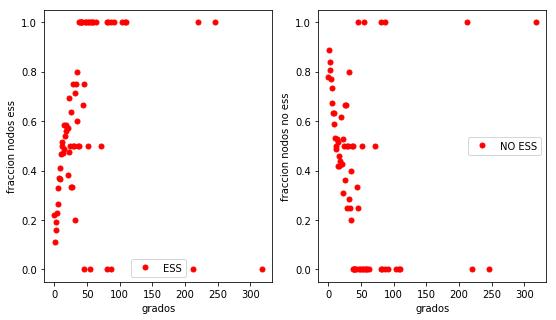

In [93]:
#Veamos como se comportan los graficos
from funciones import esenciales
from funciones import frac_ess
#G=Gs[0]
H=G.copy()
F=G.copy()
L = len(G)

(H,nodos_ess, nodos_noess)=esenciales(H,ess)
(k1, frac_es, a, b, c, d)=frac_ess(H) 

(F,nodos_ess, nodos_noess)=esenciales(F,nodos_noess) #NE le saco le paso la lista de nodos no es como la lista de los es
(k2, frac_no_es, a, b, c, d)=frac_ess(F) 


plt.figure(figsize=(9,5))

plt.subplot(1,2,1)
plt.plot(k1, frac_es,'r.',markersize=10,label='ESS')
plt.xlabel('grados')
plt.ylabel('fraccion nodos ess')
plt.legend()

plt.subplot(1,2,2)
plt.plot(k2, frac_no_es,'r.',markersize=10,label='NO ESS')
plt.xlabel('grados')
plt.ylabel('fraccion nodos no ess')
plt.legend()

plt.show()


In [94]:
from funciones import esenciales
from funciones import frac_ess

#G=Gs[0]
E = G.copy()
NE = G.copy()
G1 = G.copy()
G2 = G.copy()
L = len(G)

#lcc_ess= np.zeros(L) #componente gigante obtenida mediante remoción de nodos esenciales (eje y)
#lcc_ess[0] = L # la primera componente es el tamaño original del grafo
#lcc_no_ess= np.zeros(L) #componente gigante obtenida mediante remocion de nodos no esenciales (eje y)
#lcc_no_ess[0] = L # la primera componente es el tamaño original del grafo
lcc_no_ess=[]
lcc_ess=[]

(G1,ls_ess1, ls_no_ess1)=esenciales(G1,ess)
(k1, frac_es, a, b, c, d)=frac_ess(G1) 
(G2,ls_ess2, ls_no_ess2)=esenciales(G2,nodos_noess) #NE le paso la lista de nodos N.E. asi después uso frac_ess
(k2, frac_no_es, a, b, c, d)=frac_ess(G2) 
 
    
#Le saco todas las esenciales de una
NE.remove_nodes_from(ls_ess1) #Le saco todos los esenciales
lcc_ess = len(max(nx.connected_component_subgraphs(NE),key=len))/L
degrees_no_es = [val for (node, val) in NE.degree()]
k_no_es=np.unique(degrees_no_es)

#Ahora le saco a G2
#Veamos los grados de los nodos esenciales que saque en G1
E.remove_nodes_from(ls_no_ess1) #Le saco todos los no esenciales
degrees_es = [val for (node, val) in E.degree()]
k_es=np.unique(degrees_es)

#Quiero que armar una lista de grados no esenciales que sean parecidos a los grados esenciales
#y después encontrar sus nodos en G
#Parecidos es que el grado difiera en al menos 1 unidad
nueva_ls=[] 
for i in range(len(k_no_es)-1):
    for j in range(len(k_es)-1):
        if abs(k_no_es[i] -k_es[j])<=1:
            nueva_ls.append(k_no_es[i])
    
nueva_ls=np.unique(nueva_ls)

#Veamos cuales son los nodos no-esenciales que cumplen esa cantidad de grados
nodos_NE = [node for (node, val) in NE.degree()]
grados_NE = [val for (node, val) in NE.degree()]
nodos_NE_para_sacar=[]
for i in range(len(nueva_ls)-1):
    for j in range(len(nodos_NE)-1):
        if nueva_ls[i] == grados_NE[j]:
            nodos_NE_para_sacar.append(nodos_NE[j])
            
#Habiendo seleccionado los nodos, mezclo la lista y se la saco a G. Y hago estadística
valores=[]
for l in range(0,10000): #mil repeticiones
    G0 = G.copy()
    random.shuffle(nodos_NE_para_sacar)
    
    for i in range(0,len(nodos_NE_para_sacar)-1): 
        G0.remove_node(nodos_NE_para_sacar[i])
    
    lcc_no_ess = len(max(nx.connected_component_subgraphs(G0),key=len))/L #acá voy rellenando la lcc
    valores.append(lcc_no_ess)


valor_medio = sum(valores)/len(valores)        
error = np.std(valor_medio)
    


In [83]:
valor_medio = sum(valores)/len(valores)        
error = np.std(valor_medio)

# Creamos la tabla con las caracteristicas de las redes
haytabla = pd.DataFrame({"Red":["G"],
                        "Frac. de nodos sacando: esenciales":lcc_ess,
                        "Frac. de nodos sacando: no esenciales": valor_medio, 
                         "±": error,
                        })
haytabla


,Red,Frac. de nodos sacando: esenciales,Frac. de nodos sacando: no esenciales,±
0,G,0.560629,0.2512,0.0


In [95]:
valor_medio = sum(valores)/len(valores)        
error = np.std(valor_medio)
print(valor_medio, "±", error)

0.2511979437556818 ± 0.0
